# SAUCIE
*Sparse Autoencoders for Unsupervised Clustering, Imputation, and Embedding*

In [1]:
%matplotlib inline

import glob
import numpy as np
import os
import plotting
import tensorflow as tf
import matplotlib.pyplot as plt
import saucie
import saucie_utils as utils

from collections import OrderedDict
from saucie import Saucie
from tensorflow.python import debug as tf_debug

from saucie_utils import DataSet
from tensorflow.examples.tutorials.mnist import input_data

## Model Config

In [2]:
data_path = '/home/ubuntu/SAUCIE/mnist_data.npz'
dataset = 'mnist'
#data = utils.load_dataset(dataset, data_path)
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

data_dict = dict(_data=mnist.train.images, _labels=mnist.train.labels, _test_data=mnist.test.images, _test_labels=mnist.test.labels)
data = DataSet(labeled=True, **data_dict)

config = saucie.default_config(dataset)
print('\n'.join([str(x) for x in config.items()]))

model = Saucie(**config)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
('input_dim', 784)
('encoder_layers', [1024, 512, 256])
('emb_dim', 2)
('act_fn', 'tanh')
('d_act_fn', 'tanh')
('use_bias', True)
('loss_fn', 'bce')
('opt_method', 'adam')
('lr', 0.001)
('batch_norm', True)
('sparse_config', SparseLayerConfig(id_lam=[100.0, 0.0, 0.0],l1_lam=[0.0, 0.0, 0.0]))
('save_path', './saucie_models/mnist')


## Training Config

In [3]:
# TRAINING FLAGS
batch_size = 100     # size of batch during training
num_epochs = 20      # number of epochs to train
patience = 5         # number of epochs to train without improvement, early stopping
log_every = 100      # training loss logging frequency
save_every = 200     # checkpointing frequency
tb_graph = True      # logs graph to TensorBoard if True
tb_summs = True      # logs summaries to TensorBoard if True
debug = False        # enable tfdebug
verbose = False      # will log in debug mode if True
gpu_mem = 0.45       # percent of gpu mem to allocate

# PLOTTING FLAGS
thresh = .5          # threshold to binarize id regularized layers
save_plots = False    # saves plots if True

plot_dir = model.save_path + '/plots'

## Training Methods
Edit this to change what is saved, printed, trained, etc.

In [4]:
def train(model, sess, data, batch_size, num_steps, thresh=0.5, patience=None,
          log_freq=100, ckpt_freq=100, save_plots=True):
    """
    Args:
        model: Saucie instance to train
        sess: tf.Session object to run all ops with
        data: utils.DataSet object to load batches and test data from
        batch_size: size of batches to train with
        num_steps: number of optimizer iteration steps
        thresh: threshold for binarization
        patience: number of epochs of training allowed without improvement
        log_freq: number of steps before printing training loss
        ckpt_freq: number of steps before checkpointing model
        save_plots: boolean determining whether or not to save plots
    """
    model.epochs_trained = data.epochs_trained = model.current_epoch_.eval(sess)
    graph = sess.graph
    loss_tensors = model.loss_tensors_dict(graph)
    train_ops = dict(losses=loss_tensors, opt=model.optimize)
    test_ops = dict(losses=loss_tensors)
    test_feed_dict = {model.x_: data.test_data, model.is_training_: False}
    train_feed_dict = {model.x_: data.data, model.is_training_: False}
    best_test_losses = None
    epochs_since_improved = 0
    current_step = model.global_step_.eval(sess)
    id_lam = model._model_config['sparse_config'].id_lam
    l1_lam = model._model_config['sparse_config'].l1_lam
    cluster_layers = id_lam.nonzero()[0].tolist()

    print('Saving all run data to: {}'.format(model.save_path))

    if tb_graph or tb_summs: 
        train_writer = tf.summary.FileWriter(model.save_path + '/logs/train', graph=graph)
        test_writer = tf.summary.FileWriter(model.save_path + '/logs/test', graph=graph)
        tf.logging.debug('Saving graph to TensorBoard in {}/logs'.format(model.save_path))

    if tb_summs:
        loss_summs = [tf.summary.scalar(name, loss) for name, loss in loss_tensors.items() if type(loss) != list]
        loss_summs = tf.summary.merge(loss_summs)
        train_ops['loss_summs'] = loss_summs
        test_ops['loss_summs'] = loss_summs
        tf.logging.debug('Saving loss summaries to TensorBoard in {}/logs'.format(model.save_path))

    if save_plots:
        plot_folder = model.save_path + '/plots'
        if not os.path.exists(plot_folder):
            os.makedirs(plot_folder)
        plot_ops = OrderedDict(emb=model.encoder)
        plot_ops['cluster_acts'] = tf.get_collection('id_normalized_activations')

    for step in range(current_step + 1, num_steps + 1):
        batch = data.next_batch(batch_size)
        if data.labeled:
            batch, labels = batch
        feed_dict = {model.x_: batch, model.is_training_: True}
        train_dict = sess.run(train_ops, feed_dict=feed_dict)
        train_losses = train_dict['losses']
        if 'loss_summs' in train_dict:
            summ = train_dict['loss_summs']
            train_writer.add_summary(summ, step)
        log_str = ('epoch/step: {}/{}, '.format(model.epochs_trained, step)
                   + utils.make_dict_str(train_losses))
        tf.logging.log_every_n(tf.logging.INFO, log_str, log_freq)

        if ckpt_freq and (step % ckpt_freq) == 0:
            tf.logging.info('Saving model, after step {}'.format(step))
            model.save_model(sess, 'model', step=step)
            if save_plots:
                tf.logging.debug('Plotting middle layer embedding')
                plot_dict = sess.run(plot_ops, feed_dict=feed_dict)
                make_plots(cluster_layers, id_lam, l1_lam, plot_folder, plot_dict, data, 'cluster_layer-{}.png')

        if model.epochs_trained != data.epochs_trained:
            model.epochs_trained = sess.run(tf.assign(model.current_epoch_, data.epochs_trained))
            test_dict = sess.run(test_ops, feed_dict=test_feed_dict)
            test_losses = test_dict['losses']
            if 'loss_summs' in test_dict:
                summ = test_dict['loss_summs']
                test_writer.add_summary(summ, step)
            log_str = ('TESTING -- epoch: {}, '.format(model.epochs_trained)
                       + utils.make_dict_str(test_losses))
            tf.logging.info(log_str)
            if best_test_losses is None or best_test_losses['loss'] > test_losses['loss']:
                model.saver.save(sess, model.save_path + '/best.model')
                tf.logging.info('Best model saved after {} epochs'.format(model.epochs_trained))
                best_test_losses = test_losses
                epochs_since_improved = 0
                if save_plots:
                    tf.logging.debug('Plotting best middle layer embedding')
                    plot_dict = sess.run(plot_ops, feed_dict=test_feed_dict)
                    make_plots(cluster_layers, id_lam, l1_lam, plot_folder, plot_dict, data, 'best-cluster_layer-{}.png')
            else:
                epochs_since_improved += 1
            if patience and epochs_since_improved == patience:
                tf.logging.info('Early stopping, test loss did not improve for {} epochs.'.format(epochs_since_improved))
                tf.logging.info('Best test loss: epoch {}: '.format(model.epochs_trained - epochs_since_improved)
                                + utils.make_dict_str(best_test_losses))
                break

    tf.logging.info('Trained for {} epochs'.format(model.epochs_trained))

    print('Saved all run data to: {}'.format(model.save_path))
    return test_losses


def make_plots(cluster_layers, id_lam, l1_lam, plot_folder, plot_dict, data, title_fmt='clust_layer-{}.png'):
    for i, acts in enumerate(plot_dict['cluster_acts']):
        hl_idx = cluster_layers[i]
        save_file = plot_folder + '/emb-' + title_fmt.format(hl_idx)
        title = 'Embedding, clustered layer-{}, id_lam/l1_lam={:5.4E}/{:5.4E}'.format(hl_idx, id_lam[hl_idx], l1_lam[hl_idx])
        clusts = utils.binarize(acts, thresh)
        tf.logging.debug('Top 5 activated neurons: {}'.format(acts.max(axis=1)[:5]))
        tf.logging.debug('Mean max activation: {}'.format(acts.max(axis=1).mean()))
        tf.logging.debug('Bottom 5 max activated neurons: {}'.format(acts.max(axis=1)[-5:]))
        plotting.plot_embedding2D(plot_dict['emb'], clusts, save_file, title)
        if '_colnames' in data.__dict__:
            save_file = plot_folder + '/heatmap-' + title_fmt.format(hl_idx)
            plotting.plot_cluster_heatmap(data.test_data, clusts, data._colnames, data._markers, save_file)
    if cluster_layers == []:
        plotting.plot_embedding2D(plot_dict['emb'], np.zeros(len(plot_dict['emb'])), plot_folder + '/emb.png','Embedding, no clusters')

In [ ]:
sess.close()
tf.reset_default_graph()

## Run Training

In [5]:
if verbose:
    tf.logging.set_verbosity(tf.logging.DEBUG)
else:
    tf.logging.set_verbosity(tf.logging.INFO)
if debug:
    sess = tf_debug.LocalCLIDebugWrapperSession(sess)
    sess.add_tensor_filter('has_inf_or_nan', tf_debug.has_inf_or_nan)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_mem)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
model.build(sess)

steps_per_epoch = data.num_samples // batch_size
num_steps = steps_per_epoch * num_epochs
train(model, sess, data, batch_size, num_steps, thresh, patience, log_every, save_every, save_plots)

Saving all run data to: ./saucie_models/mnist/17-09-25-runs/0
INFO:tensorflow:epoch/step: 0/1, loss: 67824.1, recons_loss: 0.791256, id_loss: 67823.3
INFO:tensorflow:epoch/step: 0/101, loss: 3952.98, recons_loss: 0.239416, id_loss: 3952.74
INFO:tensorflow:Saving model, after step 200
INFO:tensorflow:epoch/step: 0/201, loss: 2039.2, recons_loss: 0.217255, id_loss: 2038.98
INFO:tensorflow:epoch/step: 0/301, loss: 1385.8, recons_loss: 0.196826, id_loss: 1385.6
INFO:tensorflow:Saving model, after step 400
INFO:tensorflow:epoch/step: 0/401, loss: 1769.07, recons_loss: 0.20934, id_loss: 1768.86
INFO:tensorflow:epoch/step: 0/501, loss: 1314.5, recons_loss: 0.194153, id_loss: 1314.31
INFO:tensorflow:TESTING -- epoch: 1, loss: 461253.0, recons_loss: 0.284337, id_loss: 461252.0
INFO:tensorflow:Best model saved after 1 epochs
INFO:tensorflow:Saving model, after step 600
INFO:tensorflow:epoch/step: 1/601, loss: 1449.28, recons_loss: 0.187902, id_loss: 1449.09
INFO:tensorflow:epoch/step: 1/701, los

INFO:tensorflow:Saving model, after step 6000
INFO:tensorflow:epoch/step: 10/6001, loss: 224.136, recons_loss: 0.179036, id_loss: 223.957
INFO:tensorflow:TESTING -- epoch: 11, loss: 145099.0, recons_loss: 0.348029, id_loss: 145098.0
INFO:tensorflow:epoch/step: 11/6101, loss: 257.085, recons_loss: 0.176898, id_loss: 256.908
INFO:tensorflow:Saving model, after step 6200
INFO:tensorflow:epoch/step: 11/6201, loss: 280.093, recons_loss: 0.183258, id_loss: 279.91
INFO:tensorflow:epoch/step: 11/6301, loss: 414.6, recons_loss: 0.173738, id_loss: 414.427
INFO:tensorflow:Saving model, after step 6400
INFO:tensorflow:epoch/step: 11/6401, loss: 525.037, recons_loss: 0.178559, id_loss: 524.859
INFO:tensorflow:epoch/step: 11/6501, loss: 269.203, recons_loss: 0.180242, id_loss: 269.023
INFO:tensorflow:Saving model, after step 6600
INFO:tensorflow:epoch/step: 11/6601, loss: 195.014, recons_loss: 0.171401, id_loss: 194.842
INFO:tensorflow:TESTING -- epoch: 12, loss: 123251.0, recons_loss: 0.368053, id_

OrderedDict([('loss', 102000.5),
             ('recons_loss', 0.39243916),
             ('id_loss', 102000.11)])

In [19]:
# plot
plot_folder = model.save_path + '/plots'

if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
save_file = plot_folder + '/embedding.png'

plot_ops = OrderedDict(emb=model.encoder)
plot_ops['cluster_acts'] = tf.get_collection('id_normalized_activations')

subs = np.random.choice(np.arange(len(data.data)), 5000, replace=False)
test_feed_dict = {model.x_: data.data[subs,:],
                  model.is_training_: False}

plot_dict = sess.run(plot_ops, feed_dict=test_feed_dict)

acts = plot_dict['cluster_acts'][0]
clusts = utils.binarize(acts, thresh)
plotting.plot_embedding2D(plot_dict['emb'], clusts, save_file, 'Bottleneck layer embedding')

Unique binary clusters: 16


In [7]:
# get embedding
embedding = sess.run(model.encoder, feed_dict=test_feed_dict)

In [8]:
embedding

array([[ 4.17510939, -7.40104818],
       [ 5.56869507,  1.65658391],
       [ 5.89348507, -3.94513774],
       ..., 
       [ 4.91571236, -6.03218269],
       [ 4.48567772, -6.51861906],
       [ 4.87222099, -6.59232092]], dtype=float32)

Unique binary clusters: 16


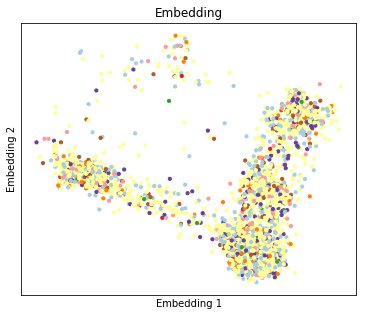

In [21]:
# plot embedding
acts = plot_dict['cluster_acts'][0]
clusts = utils.binarize(acts, thresh)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
plt.setp(ax, xticks=[], yticks=[])
ax.scatter(embedding[:,0], embedding[:,1], s=10, c=clusts, cmap="Paired")
ax.set_xlabel("Embedding 1")
ax.set_ylabel("Embedding 2")
ax.set_title("Embedding")
plt.show()

In [17]:
data._test_labels.

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])